In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline


from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay

In [2]:
phish = pd.read_csv('TrainingDatasetNew.csv')
print(phish.shape)
phish.head(10) 

(11055, 31)


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
5,-1,0,-1,1,-1,-1,1,1,-1,1,...,1,1,1,1,1,-1,1,-1,-1,1
6,1,0,-1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,-1,1,0,-1,-1
7,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,0,-1,1,0,1,-1
8,1,0,-1,1,1,-1,1,1,-1,1,...,1,1,1,-1,1,1,1,0,1,1
9,1,1,-1,1,1,-1,-1,1,-1,1,...,1,1,1,-1,0,-1,1,0,1,-1


In [3]:
print(phish.columns.values)

['having_IP_Address' 'URL_Length' 'Shortining_Service' 'having_At_Symbol'
 'double_slash_redirecting' 'Prefix_Suffix' 'having_Sub_Domain'
 'SSLfinal_State' 'Domain_registeration_length' 'Favicon' 'port'
 'HTTPS_token' 'Request_URL' 'URL_of_Anchor' 'Links_in_tags' 'SFH'
 'Submitting_to_email' 'Abnormal_URL' 'Redirect' 'on_mouseover'
 'RightClick' 'popUpWidnow' 'Iframe' 'age_of_domain' 'DNSRecord'
 'web_traffic' 'Page_Rank' 'Google_Index' 'Links_pointing_to_page'
 'Statistical_report' 'Result']


In [4]:
phish_filtered = phish.columns.drop('Result')
phish.Result.value_counts(normalize=True).to_frame() # shows the proportions of the data

,Result
1,0.556943
-1,0.443057


In [5]:
X1 = phish[phish_filtered].values
X1_fixer = phish[phish_filtered]

y1 = phish['Result'].values 

In [6]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
smote = SMOTE(random_state=1)

distributions = [] 

for train_index, _ in kf.split(X1, y1): # as I am only interested in the training set, I use _ to skip the test set.
    X_train, y_train = X1[train_index], y1[train_index]
    
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train) # applying SMOTE to training data only is essential
    
    counter = Counter(y_resampled)
    distributions.append(counter)

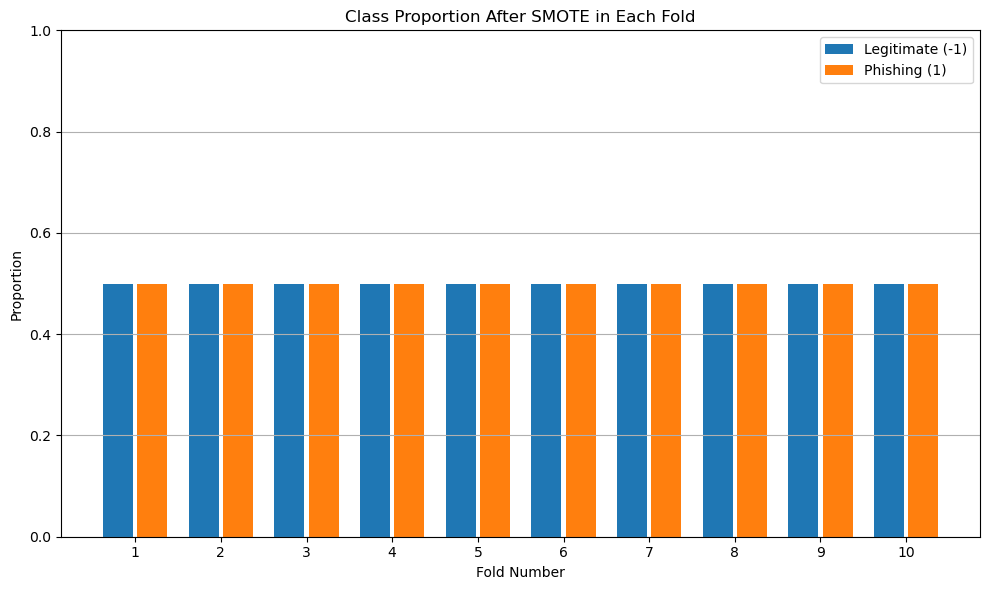

In [7]:
folds = list(range(1, len(distributions) + 1))
legit_props = [dist[-1] / (dist[1] + dist[-1]) for dist in distributions]
phish_props = [dist[1] / (dist[1] + dist[-1]) for dist in distributions]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
ax.bar([f-0.2 for f in folds], legit_props, width=bar_width, label='Legitimate (-1)')
ax.bar([f+0.2 for f in folds], phish_props, width=bar_width, label='Phishing (1)')

ax.set_xlabel('Fold Number')
ax.set_ylabel('Proportion')
ax.set_title('Class Proportion After SMOTE in Each Fold')
ax.set_xticks(folds)
ax.set_ylim(0, 1)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [8]:
rf_model = RandomForestClassifier(random_state=1)
smote = SMOTE(random_state=1)

rf_pipeline = Pipeline(steps=[
    ('smote', smote),
    ('model', rf_model)
])

kf = KFold(n_splits=10, shuffle=True, random_state=1)

start_time = time.time()

scores = cross_val_score(rf_pipeline, X1, y1, scoring='accuracy', cv=kf, n_jobs=-1)

average_accuracy = np.mean(scores)
standard_deviation = np.std(scores)

print(f"Random Forest Average Accuracy: {average_accuracy:.4f}")
print(f"Random Forest Standard Deviation: {standard_deviation:.4f}")

rf_pipeline.fit(X1, y1)
rf_model = rf_pipeline.named_steps['model']
rf_importances = pd.Series(rf_model.feature_importances_, index=X1_fixer.columns).sort_values(ascending=False)

end_time = time.time()
print(f"Total Processing Time: {end_time - start_time:.4f} seconds \n")


y_pred = cross_val_predict(rf_pipeline, X1, y1, cv=kf)
print('\n Classification Report: ')
print(classification_report(y1, y_pred))

Random Forest Average Accuracy: 0.9738
Random Forest Standard Deviation: 0.0035
Total Processing Time: 14.7667 seconds 


 Classification Report: 
              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      4898
           1       0.97      0.98      0.98      6157

    accuracy                           0.97     11055
   macro avg       0.97      0.97      0.97     11055
weighted avg       0.97      0.97      0.97     11055



In [9]:
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear', # required for L1 penalty
    max_iter=1000,
    random_state=1
)

scaler = StandardScaler()

lasso_pipeline = Pipeline(steps=[
    ('scale', scaler),
    ('smote', smote),
    ('model', lasso_model)
])

kf = KFold(n_splits=10, shuffle=True, random_state=1)

start_time = time.time()

lasso_scores = cross_val_score(lasso_pipeline, X1, y1, scoring='accuracy', cv=kf, n_jobs=-1)

average_accuracy = np.mean(lasso_scores)
standard_deviation = np.std(lasso_scores)

print(f"Lasso Model Average Accuracy: {average_accuracy:.4f}")
print(f"Lasso Model Standard Deviation: {standard_deviation:.4f}")

end_time = time.time()
print(f"Total Processing Time: {end_time - start_time:.4f} seconds \n")

lasso_pipeline.fit(X1, y1)

lasso_model = lasso_pipeline.named_steps['model']
lasso_coeffs = pd.Series(lasso_model.coef_[0], index=X1_fixer.columns)
lasso_nonzero = lasso_coeffs[lasso_coeffs != 0].sort_values(key=abs, ascending=False)

y_pred = cross_val_predict(lasso_pipeline, X1, y1, cv=kf)
print('\n Classification Report: ')
print(classification_report(y1, y_pred))

Lasso Model Average Accuracy: 0.9274
Lasso Model Standard Deviation: 0.0090
Total Processing Time: 1.3059 seconds 


 Classification Report: 
              precision    recall  f1-score   support

          -1       0.92      0.91      0.92      4898
           1       0.93      0.94      0.93      6157

    accuracy                           0.93     11055
   macro avg       0.93      0.93      0.93     11055
weighted avg       0.93      0.93      0.93     11055



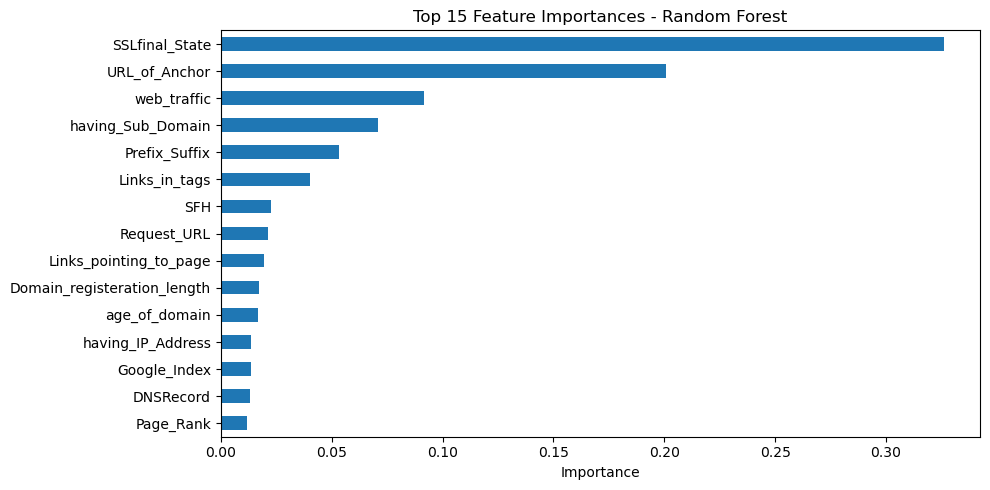

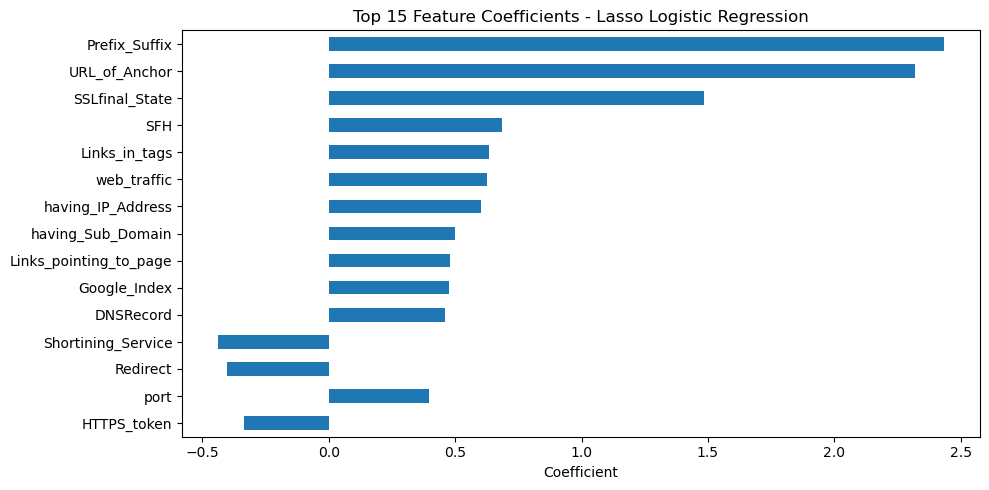

In [10]:
plt.figure(figsize=(10, 5))
rf_importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
lasso_nonzero.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Coefficients - Lasso Logistic Regression")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

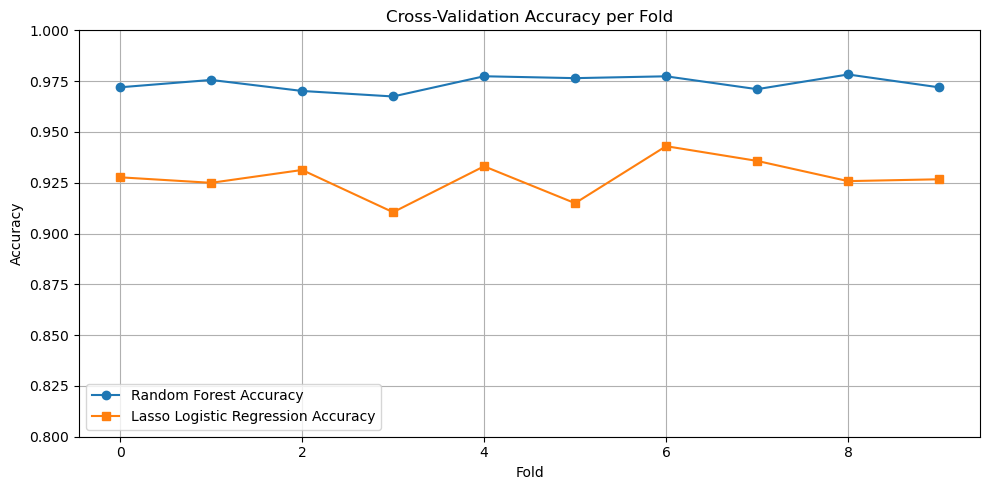

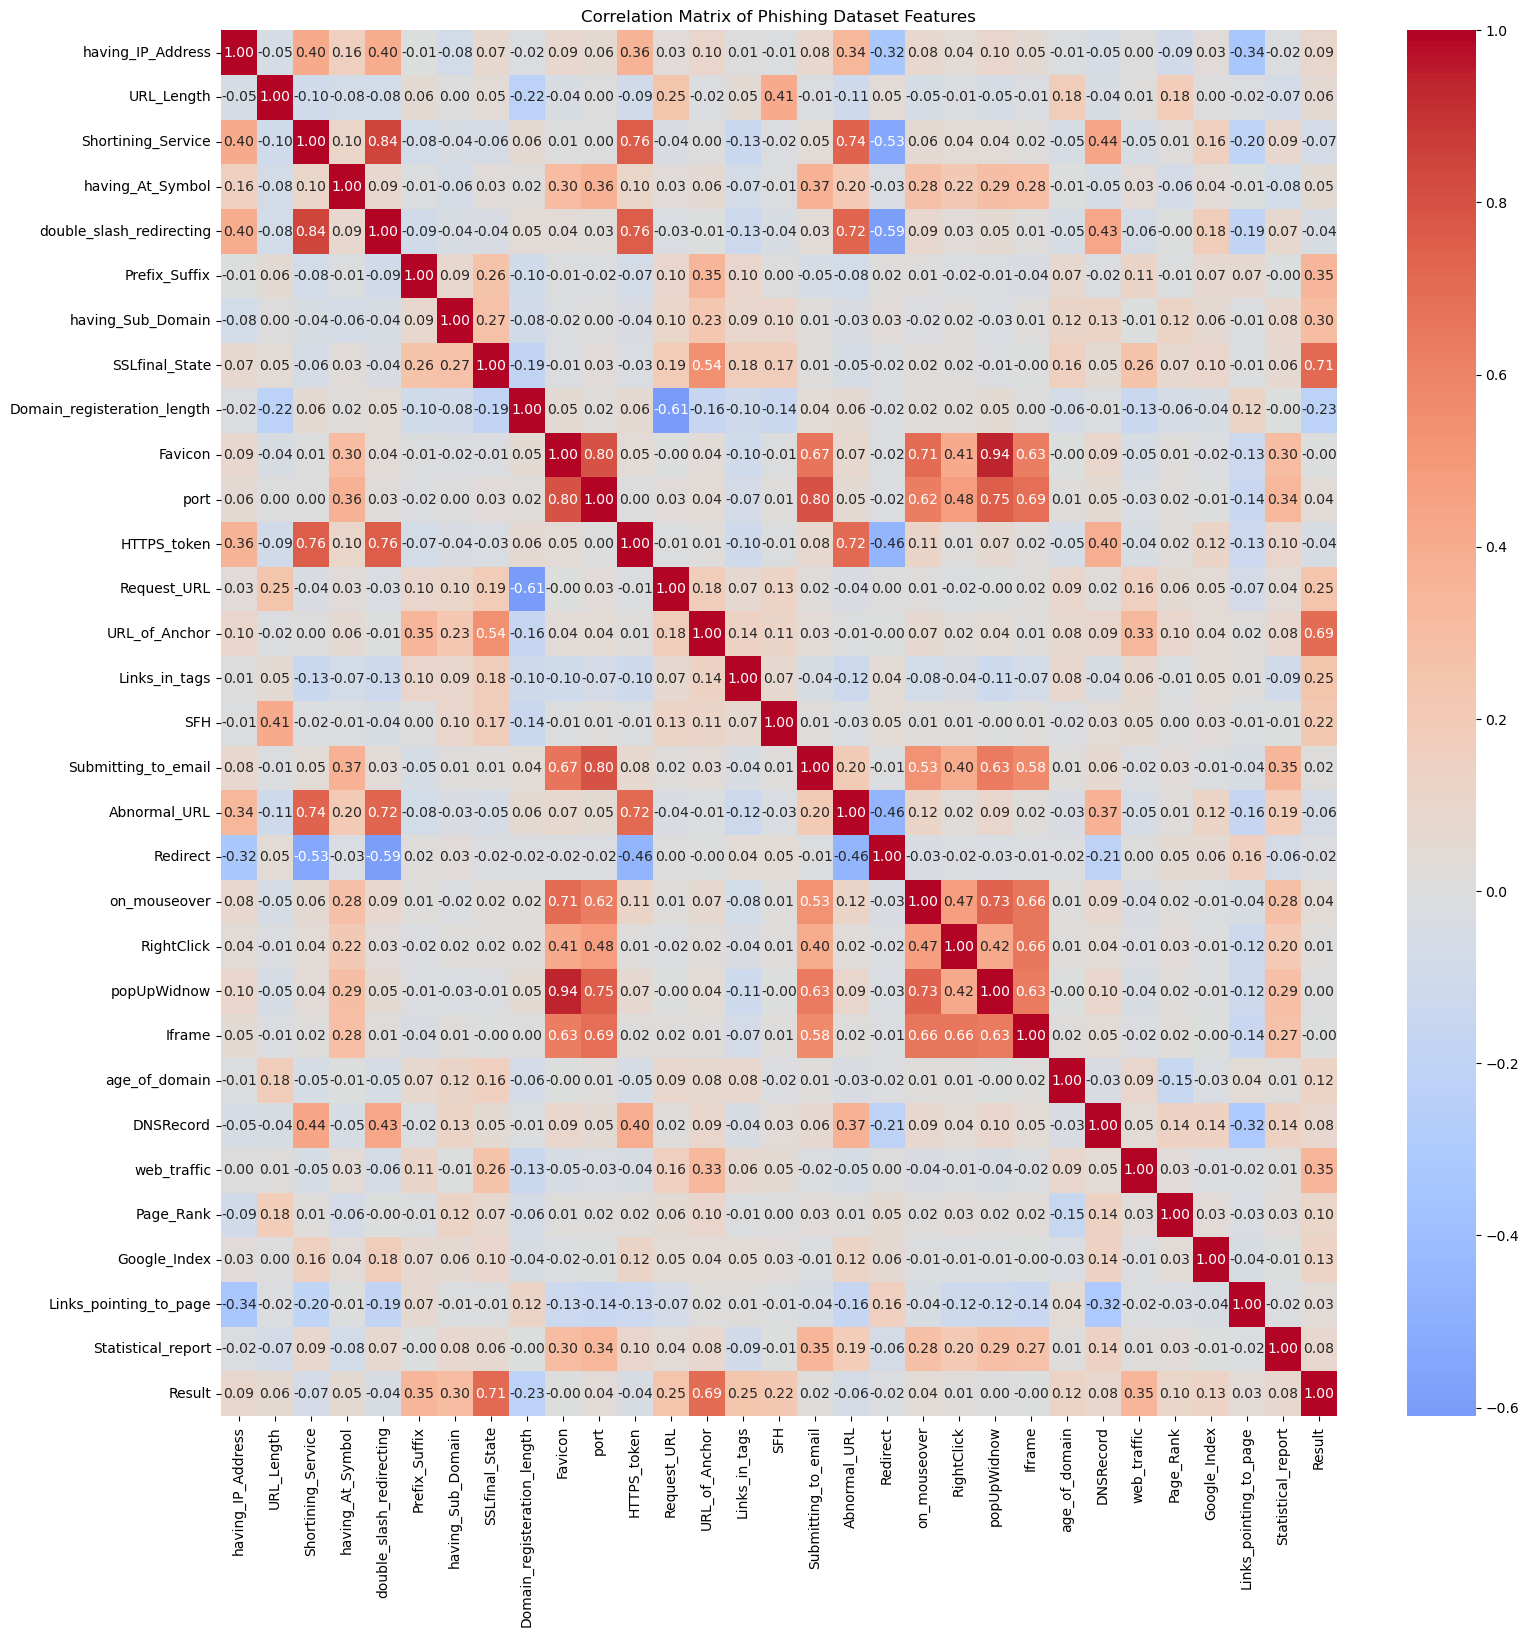

In [11]:
rf_scores = cross_val_score(rf_pipeline, X1, y1, scoring='accuracy', cv=kf, n_jobs=-1)
lasso_scores = cross_val_score(lasso_pipeline, X1, y1, scoring='accuracy', cv=kf, n_jobs=-1)

plt.figure(figsize=(10, 5))
plt.plot(rf_scores, marker='o', label='Random Forest Accuracy')
plt.plot(lasso_scores, marker='s', label='Lasso Logistic Regression Accuracy')
plt.title("Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

corr_matrix = phish.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Phishing Dataset Features")
plt.show()

In [12]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

rf_importance = pd.DataFrame({
    'Feature': phish.columns.drop('Result'),
    'Importance': rf_model.feature_importances_
})

print("Top 10 most important features (Random Forest):")
print(rf_importance.sort_values(by='Importance', ascending=False).head(10))

print("\nBottom 10 least important features (Random Forest):")
print(rf_importance.sort_values(by='Importance', ascending=True).head(10))

Top 10 most important features (Random Forest):
                   Feature  Importance
7           SSLfinal_State    0.328778
13           URL_of_Anchor    0.241854
25             web_traffic    0.076535
6        having_Sub_Domain    0.064978
5            Prefix_Suffix    0.039650
14           Links_in_tags    0.038450
15                     SFH    0.022559
28  Links_pointing_to_page    0.019146
12             Request_URL    0.018379
23           age_of_domain    0.015824

Bottom 10 least important features (Random Forest):
                     Feature  Importance
20                RightClick    0.001337
22                    Iframe    0.002192
10                      port    0.002665
19              on_mouseover    0.002994
4   double_slash_redirecting    0.003336
9                    Favicon    0.003919
17              Abnormal_URL    0.004413
29        Statistical_report    0.004824
18                  Redirect    0.004862
3           having_At_Symbol    0.004931


In [13]:

top20_features = rf_importances.head(20).index.tolist()[::-1]

top6_features = rf_importances.head(6).index.tolist()
 #try to SFH, try to reduce time if score isnt improved.

print(top6_features)
print()
print(top20_features)

['SSLfinal_State', 'URL_of_Anchor', 'web_traffic', 'having_Sub_Domain', 'Prefix_Suffix', 'Links_in_tags']

['having_At_Symbol', 'Statistical_report', 'Submitting_to_email', 'HTTPS_token', 'URL_Length', 'Page_Rank', 'DNSRecord', 'Google_Index', 'having_IP_Address', 'age_of_domain', 'Domain_registeration_length', 'Links_pointing_to_page', 'Request_URL', 'SFH', 'Links_in_tags', 'Prefix_Suffix', 'having_Sub_Domain', 'web_traffic', 'URL_of_Anchor', 'SSLfinal_State']


In [14]:
X2 = phish[top20_features]
y2 = phish['Result']

best_rf_model = RandomForestClassifier(random_state=2)
smote = SMOTE(random_state=1)

rf_pipeline = Pipeline(steps=[
    ('smote', smote),
    ('model', best_rf_model)
])

kf = KFold(n_splits=10, shuffle=True, random_state=1)

print('Top 20 Features Result scores: ')

start_time = time.time()

scores = cross_val_score(rf_pipeline, X2, y2, scoring='accuracy', cv=kf, n_jobs=-1)
print(f"Average Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")
end_time = time.time()
print(f"Total Processing Time: {end_time - start_time:.4f} seconds \n")

y_pred = cross_val_predict(rf_pipeline, X2, y2, cv=kf)
print(classification_report(y2, y_pred))

Top 20 Features Result scores: 
Average Accuracy: 0.9725
Standard Deviation: 0.0039
Total Processing Time: 9.1090 seconds 

              precision    recall  f1-score   support

          -1       0.97      0.96      0.97      4898
           1       0.97      0.98      0.98      6157

    accuracy                           0.97     11055
   macro avg       0.97      0.97      0.97     11055
weighted avg       0.97      0.97      0.97     11055



In [15]:
X2 = phish[top6_features]
y2 = phish['Result']

best_rf_model = RandomForestClassifier(random_state=2)
smote = SMOTE(random_state=1)

rf_pipeline = Pipeline(steps=[
    ('smote', smote),
    ('model', rf_model)
])

kf = KFold(n_splits=10, shuffle=True, random_state=2)

print('Top 6 Features Result scores: ')

start_time = time.time()

scores = cross_val_score(rf_pipeline, X2, y2, scoring='accuracy', cv=kf, n_jobs=-1)
print(f"Average Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

end_time = time.time()
print(f"Total Processing Time: {end_time - start_time:.4f} seconds \n")

y_pred = cross_val_predict(rf_pipeline, X2 , y2, cv=kf)
print(classification_report(y2, y_pred))

Top 6 Features Result scores: 
Average Accuracy: 0.9351
Standard Deviation: 0.0041
Total Processing Time: 3.0933 seconds 

              precision    recall  f1-score   support

          -1       0.93      0.93      0.93      4898
           1       0.94      0.94      0.94      6157

    accuracy                           0.94     11055
   macro avg       0.93      0.93      0.93     11055
weighted avg       0.94      0.94      0.94     11055



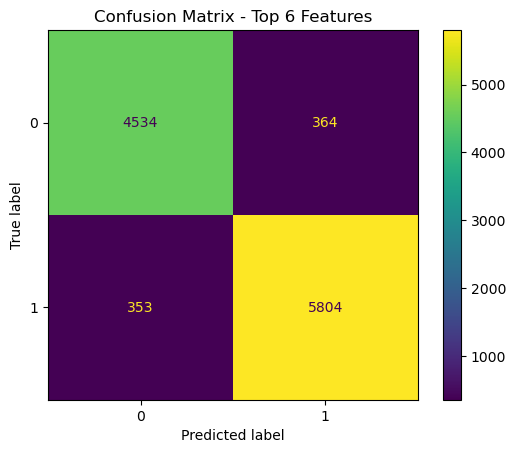

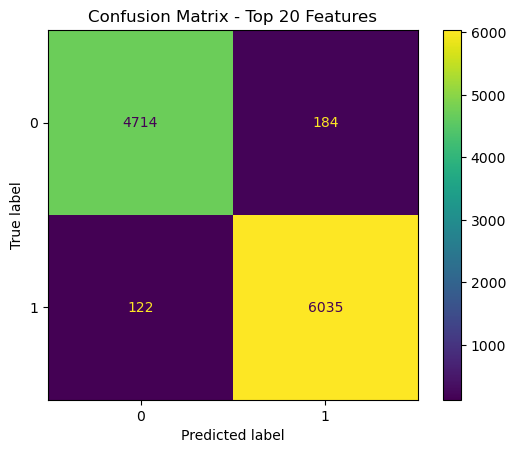

In [16]:
X6 = phish[top6_features]
y = phish['Result']

y_pred6 = cross_val_predict(rf_pipeline, X6, y, cv=kf)
cm6 = confusion_matrix(y, y_pred6)
disp6 = ConfusionMatrixDisplay(confusion_matrix=cm6)
disp6.plot()
plt.title("Confusion Matrix - Top 6 Features")
plt.show()

X20 = phish[top20_features]

y_pred20 = cross_val_predict(rf_pipeline, X20, y, cv=kf)
cm20 = confusion_matrix(y, y_pred20)
disp20 = ConfusionMatrixDisplay(confusion_matrix=cm20)
disp20.plot()
plt.title("Confusion Matrix - Top 20 Features")
plt.show()
